In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [9]:
#Retrieve the table names
table_names = base.metadata.tables.keys()
print("Table names in the database:")
for table_name in table_names:
    print(table_name)

Table names in the database:
measurement
station


In [26]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
#checking for first row in measurements table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x149b5ca50>,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

In [29]:
# Find the most recent date in the data set.
latest_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date

('2017-08-23',)

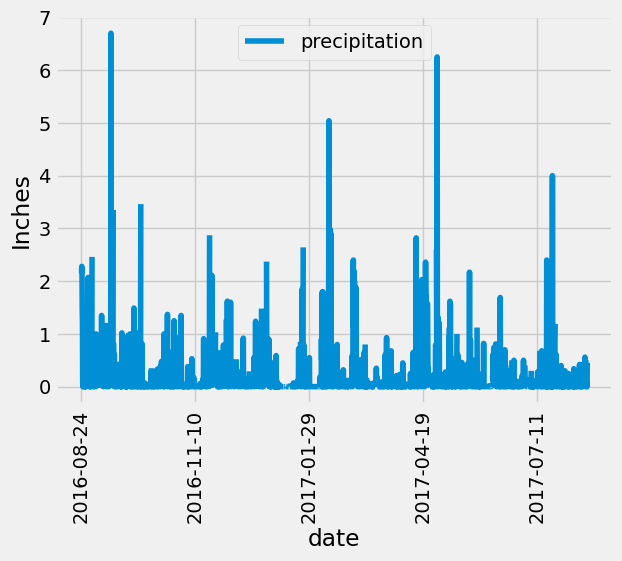

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Calculate the date one year ago from the last date in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date = datetime.strptime(last_date.date, '%Y-%m-%d')
one_year_ago = last_date - timedelta(days=365)

# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(
    measurement.date >= one_year_ago,
    measurement.date <= last_date
    ).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df=pd.DataFrame(results, columns=['date', 'precipitation'])


# Sort the dataframe by date
prcp_df.sort_values("date", inplace=True)
prcp_df.set_index("date", inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(ylabel="Inches")
plt.legend(loc='upper center')

plt.xticks(rotation=90)
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prcp_df.describe()
summary_statistics

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number of stations in the dataset
no_of_stations = session.query(station).\
    filter(station.id).count()

no_of_stations

9

In [32]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(station.station).all()

[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order. 

most_active_stations = session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()

for active_station in most_active_stations:
    print(f"{active_station[0]}, {active_station[1]}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temp_stats=session.query(func.min(measurement.tobs), 
                       func.max(measurement.tobs),
                       func.avg(measurement.tobs)).filter(measurement.station == most_active_station_id).first()

print(f"For station {most_active_station_id}:")
print(f"The Lowest Temperature:{temp_stats[0]}°F")
print(f"The Highest Temperature:{temp_stats[1]}°F")
print(f"The Average Temperature:{temp_stats[2]}°F")

For station USC00519281:
The Lowest Temperature:54.0°F
The Highest Temperature:85.0°F
The Average Temperature:71.66378066378067°F


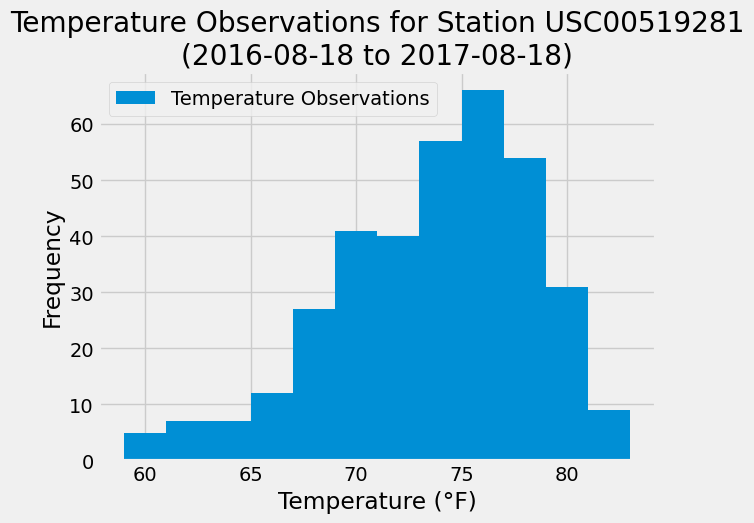

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define the most active station identifier 
most_active_station_id = 'USC00519281'

# Calculate the date one year ago from the last date in the database
last_date = session.query(measurement.date).filter(measurement.station == most_active_station_id).order_by(measurement.date.desc()).first()
last_date = datetime.strptime(last_date.date, '%Y-%m-%d')
one_year_ago = last_date - timedelta(days=365)

# Query the temperature observations for the most active station in the last 12 months
results = session.query(measurement.tobs).filter(
    measurement.station == most_active_station_id,
    measurement.date >= one_year_ago,
    measurement.date <= last_date
    ).all()

# Extract the TOBS data from the query results
tobs_data = [result.tobs for result in results]

# Save the query results to a Pandas DataFrame
hist_df = pd.DataFrame(tobs_data)

# Create a histogram
plt.hist(hist_df, bins=12, label='Temperature Observations')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.title(f'Temperature Observations for Station {most_active_station_id}\n({one_year_ago.strftime("%Y-%m-%d")} to {last_date.strftime("%Y-%m-%d")})')
plt.show()

# Close Session

In [36]:
# Close Session
session.close()